In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import re
import preprocessing_mojule 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import preprocessing_mojule as pm
from urllib.request import urlopen
import pickle
import japanize_matplotlib 
from sklearn.metrics import mean_squared_error

In [111]:
class Results:
    def __init__(self, pre_df):
        self.pre_df = pre_df
        self.before_scale = None
        self.post_df = self.preprocessing(self.pre_df)
        
    
    def preprocessing(self, pre_df):
        results = pre_df.copy()
        results = results[~(results["着順"].astype(str).str.contains("\D"))]
        results["着順"] = results["着順"].astype(int)
        results["性齢"] = results["性齢"].astype(str)
        results["性"] = results["性齢"].map(lambda x:x[0])
        results["年齢"] = results["性齢"].map(lambda x:x[1:])
        results["体重"] = results["馬体重"].map(lambda x:x[:3])
        results["増減"] = results["馬体重"].str.split("(").map(lambda x:int(x[-1][:-1]))
        results["人気"] = results["人気"].astype(int)
        results["年齢"] = results["年齢"].astype(int)
        results["体重"] = results["体重"].astype(float)
        results["単勝"] = results["単勝"].astype(float)
        results = pd.concat([results, pd.get_dummies(results["性"])], axis=1)
        results["勝率*騎乗回数"] = results["勝率"] * results["騎乗回数"]
        results["連対率*騎乗回数"] = results["連対率"] * results["騎乗回数"]
        results["複勝率*騎乗回数"] = results["複勝率"] * results["騎乗回数"]
        
        
        results["増減/体重"] = results["増減"] / results["体重"]  
        results["斤量/体重"] = results["斤量"] / results["体重"]
        
        features_addinfo = [
            '着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手', 'タイム', '着差', '単勝', '人気',
       '馬体重', '調教師', 'horse_id', 'jockey_id', 'length', 'race_type', 'weather',
       'condition', 'date', '騎乗回数', '勝率', '連対率', '複勝率', '賞金_ave', '賞金_sum',
       '順番_ave', '賞金_ave_2', '賞金_sum_2', '順番_ave_2', '賞金_ave_4', '賞金_sum_4',
       '順番_ave_4', '順番_ave_distorted', '順番_ave_2_distorted',
       '順番_ave_4_distorted', '芝', 'ダ', '障', '短距離', 'マイル距離', '芝_ave_order',
       'ダ_ave_order', '短距離_ave_order', 'マイル距離_ave_order', '芝得意', '短距離得意',
       '中距離_ave_order', '長距離_ave_order', 'マイル距離得意', '中距離得意', '長距離得意',
       'length_match', 'race_type_match', 'horse_ped_score', 'タイム_線形',
       'score', 
        ]
        
        drop_features = [
            "枠番", "馬名", "性齢", "騎手","着差", "馬体重", "調教師", "horse_id",
            "jockey_id",  "race_type", "weather", "condition", "date", "性",
            '芝', 'ダ', '障', '短距離', 'マイル距離', '芝_ave_order',
            'ダ_ave_order', '短距離_ave_order', 'マイル距離_ave_order', '芝得意', '短距離得意',
            '中距離_ave_order', '長距離_ave_order', 'マイル距離得意', '中距離得意', '長距離得意',
            "タイム", "タイム_線形", '賞金_ave_4', '賞金_sum_4','順番_ave_4', '順番_ave_distorted', '順番_ave_2_distorted',
            '順番_ave_4_distorted', 
        ]
        results = results.drop(drop_features, axis=1)
        results = results.astype(float)
        results["着順"] = results["着順"].astype(int)
        self.before_scale = results
        
        keep_features = ['着順', 'セ', '牝', '牡', "馬番", "length_match", "race_type_match", "人気", "単勝", "score"]
        scaler = pm.CustomSTDScaler(keep_features)
        results = scaler.fit_transform(results)
    
        return results

class Evaluater():
    def __init__(self, X, y):
        race = list(X.index.unique())
        race_tmp, race_test = train_test_split(race, shuffle=True, test_size=0.3)
        race_train, race_val = train_test_split(race_tmp, shuffle=True, test_size=0.3)
        self.__X_train, self.__y_train = X[X.index.isin(race_train)], y[X.index.isin(race_train)]
        self.__X_test, self.__y_test = X[X.index.isin(race_test)], y[X.index.isin(race_test)]
        self.__X_val, self.__y_val = X[X.index.isin(race_val)], y[X.index.isin(race_val)]
        self.__params = None
        self.__params = self.params
        self.__model = None
        self.y_test = self.__y_test
        self.X_test = self.__X_test
        return 
    def fit_reset(self):
        race = list(X.index.unique())
        race_tmp, race_test = train_test_split(race, shuffle=True, test_size=0.3)
        race_train, race_val = train_test_split(race_tmp, shuffle=True, test_size=0.3)
        self.__X_train, self.__y_train = X[X.index.isin(race_train)], y[X.index.isin(race_train)]
        self.__X_test, self.__y_test = X[X.index.isin(race_test)], y[X.index.isin(race_test)]
        self.__X_val, self.__y_val = X[X.index.isin(race_val)], y[X.index.isin(race_val)]
        self.y_test = self.__y_test
        self.X_test = self.__X_test
        self.fit()
    @property
    def params(self):
        if self.__params == None:
            param = {'objective': 'regression',
                     'random_state': 57,
                     'metric': 'l2',
                     'feature_pre_filter': False,
                     'lambda_l1': 0.15883047646498394,
                     'lambda_l2': 9.85103023641964,
                     'num_leaves': 4,
                     'feature_fraction': 0.5,
                     'bagging_fraction': 0.9223910437388337,
                     'bagging_freq': 5,
                     'min_child_samples': 20,
                     'num_iterations': 1000}
        self.__params = param
        return self.__params
    @params.setter
    def params(self, params):
        self.__params = params
    @property
    def model(self):
        return self.__model
    def predict(self, threshold=0):
        self.fit_reset()
        pred = self.__model.predict(self.__X_test.drop(["馬番", "単勝", "人気"], axis=1, inplace=False))
        df = pd.DataFrame(pred, index=self.__X_test.index, columns=["pred"])
        df["mean"] = df.groupby(df.index)["pred"].transform("mean")
        df["std"] = df.groupby(df.index)["pred"].transform("std")
        df["pred_scaled"] = (df["pred"] - df["mean"]) / df["std"]
        self.pred = pred.copy()
        self.pred[df["pred_scaled"] >= threshold] = 1
        self.pred[df["pred_scaled"] < threshold] = 0
        return self.pred
    def fit(self):
        verbose_eval = -1
        self.__model = lgb.LGBMRegressor(**self.__params)
        self.__model.fit(
            self.__X_train.drop(["馬番", "単勝", "人気"], axis=1, inplace=False), self.__y_train, 
            eval_metric='mean_squared_error', 
            eval_set=[(self.__X_val.drop(["馬番", "単勝", "人気"], axis=1, inplace=False), self.__y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=10, 
                        verbose=False), # early_stopping用コールバック関数
                    lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
                 )
        return self.__model

    def importance(self):
        self.fit()
        importances = pd.DataFrame(
            {
                "features":self.__X_train.drop(["馬番", "単勝", "人気"], axis=1, inplace=False).columns, "importance":self.__model.feature_importances_
            })
            
        importances =  importances.sort_values("importance", ascending=False)
        return importances
    def cal(self, pay_dict, threshold=0, fukusho=False, tansho=False, umaren=False, repeat=1):
        def cal_tansho(x):
            race_id = x.name
            horse_number = int(x["馬番"])
            ninki = x["人気"]
            odds = x[1]
            df = pay_dict[race_id]
            df_tansho = df.loc["単勝"]
            df_tansho["該当馬"] = list(map(int, df_tansho["該当馬"]))
            df_tansho["金"] = list(map(str, df_tansho["金"]))
            invested = 100 
            payback = 0
            if horse_number in df_tansho["該当馬"]:
                idx = df_tansho["該当馬"].index(horse_number)
                tmp = df_tansho["金"][idx]
                tmp = tmp.split(",")
                payback += int("".join(tmp))
            return (payback, invested)
        def cal_umaren(x):
            race_id = x.name
            pay_df = pay_dict[race_id]
            df_tansho = pay_df.loc["単勝"]
            df_fukusho = pay_df.loc["複勝"]
            df_umaren = pay_df.loc["馬連"]
            umaban_list = x["馬番_list"]
            umaban_list = list(map(int, umaban_list))
            length = len(umaban_list)
            invested = 0
            payback_sum = 0
            df_tansho["該当馬"] = list(map(int, df_tansho["該当馬"]))
            df_fukusho["該当馬"] = list(map(int, df_fukusho["該当馬"]))
            df_umaren["該当馬"] = list(map(int, df_umaren["該当馬"]))
            df_tansho["金"] = list(map(str, df_tansho["金"]))
            df_fukusho["金"] = list(map(str, df_fukusho["金"]))
            df_umaren["金"] = list(map(str, df_umaren["金"]))
            #単勝の処理
            for umaban in umaban_list:
                invested += 100 * 1
                if umaban in df_tansho["該当馬"]:
                    idx = df_tansho["該当馬"].index(umaban)
                    tmp = df_tansho["金"][idx]
                    tmp = tmp.split(",")
                    tmp = int("".join(tmp))
                    payback_sum += tmp
            invested += ((length * (length - 1)) // 2) * 100        
            if set(df_umaren["該当馬"]) <= set(umaban_list):
                tmp = df_tansho["金"][0]
                tmp = tmp.split(",")
                tmp = int("".join(tmp))
                payback_sum += tmp
            return (payback_sum, invested)    
        
        def cal_fukusho(x):
            race_id = x.name
            pay_df = pay_dict[race_id]
            df_tansho = pay_df.loc["単勝"]
            df_fukusho = pay_df.loc["複勝"]
            umaban_list = x["馬番_list"]
            umaban_list = list(map(int, umaban_list))
            length = len(umaban_list)
            invested = 0
            payback_sum = 0
            df_tansho["該当馬"] = list(map(int, df_tansho["該当馬"]))
            df_fukusho["該当馬"] = list(map(int, df_fukusho["該当馬"]))
            df_tansho["金"] = list(map(str, df_tansho["金"]))
            df_fukusho["金"] = list(map(str, df_fukusho["金"]))
            #単勝の処理
            for umaban in umaban_list:
                invested += 100 * 1
                if umaban in df_tansho["該当馬"]:
                    idx = df_tansho["該当馬"].index(umaban)
                    tmp = df_tansho["金"][idx]
                    tmp = tmp.split(",")
                    tmp = int("".join(tmp))
                    payback_sum += tmp
            if length >= 2:
                invested = 0
                payback_sum = 0
                for umaban in umaban_list:
                    invested += 100 * 1
                    if umaban in df_fukusho["該当馬"]:
                        idx = df_fukusho["該当馬"].index(umaban)
                        tmp = df_fukusho["金"][idx]
                        tmp = tmp.split(",")
                        tmp = int("".join(tmp))
                        payback_sum += tmp

            return (payback_sum, invested)    
            
        
        if all([not tansho, not fukusho, not umaren]):
            raise ValueError("賭け方を指定してください") 
        if sum([tansho, fukusho, umaren]) != 1:
            raise ValueError("賭け方の指定は一つだけです")
        invested_mean = []
        payback_sum_mean = [] 
        div_mean = []
        for i in range(repeat):
            pred = self.predict(threshold)
            parchaced = self.__X_test[pred==1][["馬番", "単勝", "人気"]]
            if tansho:
                payback = parchaced.apply(lambda x:cal_tansho(x)[0], axis=1)
                invested = parchaced.apply(lambda x:cal_tansho(x)[1], axis=1)
                if invested.shape[0] == 0:
                    invested = 0
                    payback_sum = 0
                else:
                    invested = sum(invested)
                    payback_sum = sum(payback)
            if fukusho:
                parchaced['馬番_list'] = parchaced.groupby(parchaced.index)['馬番'].apply(list)
                parchaced = parchaced[~parchaced.index.duplicated(keep='first')]
                payback = parchaced.apply(lambda x:cal_fukusho(x)[0], axis=1)
                invested = parchaced.apply(lambda x:cal_fukusho(x)[1], axis=1)
                if invested.shape[0] == 0:
                    invested = 0
                    payback_sum = 0
                else:
                    invested = sum(invested)
                    payback_sum = sum(payback)
            if umaren:
                parchaced['馬番_list'] = parchaced.groupby(parchaced.index)['馬番'].apply(list)
                parchaced = parchaced[~parchaced.index.duplicated(keep='first')]
                payback = parchaced.apply(lambda x:cal_umaren(x)[0], axis=1)
                invested = parchaced.apply(lambda x:cal_umaren(x)[1], axis=1)
                if invested.shape[0] == 0:
                    invested = 0
                    payback_sum = 0
                else:
                    invested = sum(invested)
                    payback_sum = sum(payback)
            if isinstance(invested, (int, float)):
                if invested == 0:
                    div = 0
                    payback_sum = 0
            else:
                invested = 0
                div = 0
                payback_sum = 0
                print(f"investedが数値じゃありません{threshold}")
            div = payback_sum - invested   
            invested_mean.append(invested)
            payback_sum_mean.append(payback_sum)
            div_mean.append(div)
        return sum(invested_mean)/repeat, sum(payback_sum_mean)/repeat, sum(div_mean)/repeat
    def visualize(self, bins=100, fukusho=False, tansho=False, umaren=False, repeat=1):
        thresholds = []
        kaishuuritu = []
        divs = []
        investeds = []
        res = {}
        for i in tqdm(range(bins + 2)):
            threshold = -1 + (i / bins)*4
            thresholds.append(threshold)
            invested, payback_sum, div = self.cal(pay_dict, threshold, tansho=tansho, fukusho=fukusho, umaren=umaren, repeat=repeat)
            divs.append(div)
            investeds.append(invested/100)
            if invested == 0:
                if payback_sum == 0:
                    kaishuuritu.append(1*100)    
                continue
            kaishuuritu.append((payback_sum / invested)*100)
        res["invested"] = np.array(investeds)
        res["kaishuuritu"] = np.array(kaishuuritu)
        res["div"] = np.array(divs)
        res["threshold"] = np.array(thresholds)
        return res   
    def integral(self, d=None, h=None, bins=100, fukusho=True):
        def private_integral(x, y):
            z = [(d, h) for d, h in zip(x, y)]
            z.sort()
            x = np.array([i[0] for i in z])
            x = x/max(x)
            y = np.array([i[1] for i in z])
            y = y - 100

            length = x.shape[0]
            S = 0
            for i in range(length - 1):
                d = x[i + 1] - x[i]
                a = y[i]
                b = y[i + 1]
                s = (y[i] + y[i + 1]) * d / 2
                S += s
            return S   
        if d is None is h == None:
            res = self.visualize(self.X_test, bins=bins, fukusho=fukusho)
            d, h = res["invested"], res["kaishuuritu"]
        return private_integral(d, h)

In [3]:
results_addinfo = pd.read_pickle("result_addinfo.pickle")
horse_history = pd.read_pickle("horse_history.pickle")
jockey_history = pd.read_pickle("jockey_history.pickle")
dict_horse_history = {idx: horse_history.loc[idx] for idx in horse_history.index.unique()}

with open("pay_dict.pickle", "rb") as f:
    pay_dict = pickle.load(f)
with open("dict_horse_ped.pickle", "rb") as f:
    horse_ped_dict = pickle.load(f)

In [112]:
instance = Results(results_addinfo)
data = instance.post_df
th = 3
X, y = data.drop(["着順"], axis=1), -data["着順"]

drop_features = [
        '賞金_ave_2', '賞金_sum_2', 
        '増減', "連対率", "連対率*騎乗回数",  "タイム/length", 
       "騎乗回数", "score", "length", 
]
X.drop(drop_features, axis=1, inplace=True)

In [113]:
ev = Evaluater(X, y)

In [114]:
ev.importance()

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

,features,importance
3,賞金_ave,64
6,順番_ave_2,52
10,年齢,46
5,順番_ave,41
2,複勝率,40
0,斤量,33
17,増減/体重,29
7,length_match,24
9,horse_ped_score,22
1,勝率,21


In [115]:

dic1 = ev.visualize(fukusho=True, bins=30, repeat=3)
dic2 = ev.visualize(umaren=True, bins=30, repeat=3)
dic = ev.visualize(tansho=True, bins=30, repeat=3)

  0%|          | 0/32 [00:00<?, ?it/s]

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

feature_fraction, val_score: inf:   0%|                                                        | 0/7 [1:46:57<?, ?it/s]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Start training from score -7.635334
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2398
[LightGBM] [Info] Number of data points in the train set: 21126, number of used features: 19
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2410
[LightGBM] [Info] Number of data points in the train set: 21027, number of used features: 19
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[Li

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 21146, number of used features: 19
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[Li

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current v

C:\Users\kanat\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.15883047646498394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15883047646498394
[LightGBM] [Warning] lambda_l2 is set=9.85103023641964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85103023641964
[LightGBM] [Warning] bagging_fraction is set=0.9223910437388337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9223910437388337
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


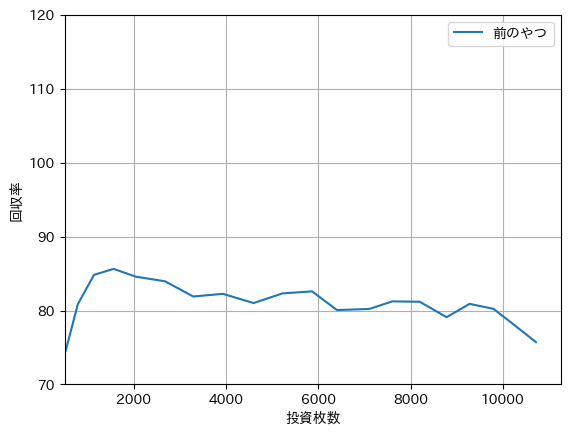

In [121]:
a = 0
plt.plot(dic1["invested"], dic1["kaishuuritu"], label="前のやつ")
#plt.plot(dic1["invested"], dic1["kaishuuritu"], label="今のやつ")
#plt.fill_between(dic["invested"], dic["kaishuuritu"] - a*dic["std"], dic["kaishuuritu"] + a*dic["std"], alpha=0.2)
plt.legend()
plt.xlabel("投資枚数")
plt.ylabel("回収率")
plt.xlim(500, )
plt.ylim(70, 120)
plt.grid()
plt.show()

In [17]:
dic1

{'invested': array([5263.8, 4855.4, 4462.2, 4108.6, 3795.2, 3470.8, 3196.5, 2928.9,
        2654.7, 2427.2, 2211.8, 1976.8, 1792.4, 1588.5, 1414.9, 1232.4,
        1077.4,  928.4,  794.7,  677.7,  576.5,  469.6,  381.5,  309.3,
         233.3,  185.2,  144.2,  101.2,   75.5,   45.9,   31.8,   17.5]),
 'kaishuuritu': array([ 94.85428778,  94.57943733,  98.32504146,  95.57245777,
         97.75163364,  97.01077561,  95.59799781,  93.83898392,
         91.14024184,  90.23154252,  92.11501944,  92.33559288,
         92.56694934,  95.10607491,  93.76987773,  95.62885427,
         94.39019863,  96.29470056,  92.69284007,  92.77999115,
         95.14830876,  95.18313458, 101.24770642, 100.4138377 ,
        108.15687955, 100.6425486 , 100.39528433,  97.78656126,
        108.98013245,  99.30283224,  90.75471698,  71.14285714]),
 'div': array([-27086., -26319.,  -7474., -18191.,  -8533., -10375., -14071.,
        -18045., -23520., -23710., -17440., -15151., -13323.,  -7774.,
         -8815.,  -5

In [90]:
tmp_x, y_train, tmp_y, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(tmp_x, tmp_y, test_size=0.3, shuffle=False)

In [91]:
import optuna.integration.lightgbm as lgb_o
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_val = lgb_o.Dataset(X_val.values, y_val.values)

In [92]:
params = {
    "objective":"regression",
    "random_state":57,
    "metric":"mean_squared_error"
}

lgb_clf_o = lgb_o.train(params, 
                        lgb_train, valid_sets=(lgb_train, lgb_val),
                       )


[I 2023-12-22 16:27:08,190] A new study created in memory with name: no-name-1484f0a2-30d1-44a3-b820-317bd59b6a22

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.739529:  14%|######2                                     | 1/7 [00:05<00:31,  5.23s/it][I 2023-12-22 16:27:13,493] Trial 0 finished with value: 12.739529082180086 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 12.739529082180086.

feature_fraction, val_score: 12.739529:  14%|######2                                     | 1/7 [00:05<00:31,  5.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.739529:  29%|############5                               | 2/7 [00:08<00:21,  4.30s/it][I 2023-12-22 16:27:17,131] Trial 1 finished with value: 12.744213050620392 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 12.739529082180086.

feature_fraction, val_score: 12.739529:  29%|############5                               | 2/7 [00:08<00:21,  4.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.739529:  43%|##################8                         | 3/7 [00:12<00:15,  3.93s/it][I 2023-12-22 16:27:20,619] Trial 2 finished with value: 12.807347956441681 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 12.739529082180086.

feature_fraction, val_score: 12.739529:  43%|##################8                         | 3/7 [00:12<00:15,  3.93s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.739529:  57%|#########################1                  | 4/7 [00:16<00:12,  4.02s/it][I 2023-12-22 16:27:24,766] Trial 3 finished with value: 12.793895388871933 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 12.739529082180086.

feature_fraction, val_score: 12.739529:  57%|#########################1                  | 4/7 [00:16<00:12,  4.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.689902:  71%|###############################4            | 5/7 [00:19<00:07,  3.66s/it][I 2023-12-22 16:27:27,801] Trial 4 finished with value: 12.689901626807501 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 12.689901626807501.

feature_fraction, val_score: 12.689902:  71%|###############################4            | 5/7 [00:19<00:07,  3.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.689902:  86%|#####################################7      | 6/7 [00:22<00:03,  3.44s/it][I 2023-12-22 16:27:30,816] Trial 5 finished with value: 12.707379739335854 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 12.689901626807501.

feature_fraction, val_score: 12.689902:  86%|#####################################7      | 6/7 [00:22<00:03,  3.44s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction, val_score: 12.683367: 100%|############################################| 7/7 [00:26<00:00,  3.75s/it]

num_leaves, val_score: 12.683367:   0%|                                                         | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.683367:   5%|##4                                              | 1/20 [00:13<04:22, 13.81s/it][I 2023-12-22 16:27:48,305] Trial 7 finished with value: 13.141425559570084 and parameters: {'num_leaves': 78}. Best is trial 7 with value: 13.141425559570084.

num_leaves, val_score: 12.683367:   5%|##4                                              | 1/20 [00:13<04:22, 13.81s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.683367:  10%|####9                                            | 2/20 [00:27<04:02, 13.48s/it][I 2023-12-22 16:28:01,561] Trial 8 finished with value: 13.190980151959247 and parameters: {'num_leaves': 189}. Best is trial 7 with value: 13.141425559570084.

num_leaves, val_score: 12.683367:  10%|####9                                            | 2/20 [00:27<04:02, 13.48s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.683367:  15%|#######3                                         | 3/20 [00:40<03:51, 13.61s/it][I 2023-12-22 16:28:15,321] Trial 9 finished with value: 13.310614914925686 and parameters: {'num_leaves': 235}. Best is trial 7 with value: 13.141425559570084.

num_leaves, val_score: 12.683367:  15%|#######3                                         | 3/20 [00:40<03:51, 13.61s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.611687:  20%|#########8                                       | 4/20 [00:44<02:32,  9.56s/it][I 2023-12-22 16:28:18,672] Trial 10 finished with value: 12.611687137143532 and parameters: {'num_leaves': 26}. Best is trial 10 with value: 12.611687137143532.

num_leaves, val_score: 12.611687:  20%|#########8                                       | 4/20 [00:44<02:32,  9.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.611687:  25%|############2                                    | 5/20 [00:46<01:45,  7.06s/it][I 2023-12-22 16:28:21,304] Trial 11 finished with value: 12.683367260057057 and parameters: {'num_leaves': 31}. Best is trial 10 with value: 12.611687137143532.

num_leaves, val_score: 12.611687:  25%|############2                                    | 5/20 [00:46<01:45,  7.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.520430:  30%|##############7                                  | 6/20 [00:49<01:16,  5.49s/it][I 2023-12-22 16:28:23,734] Trial 12 finished with value: 12.520429505708536 and parameters: {'num_leaves': 20}. Best is trial 12 with value: 12.520429505708536.

num_leaves, val_score: 12.520430:  30%|##############7                                  | 6/20 [00:49<01:16,  5.49s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.224558:  35%|#################1                               | 7/20 [00:51<00:57,  4.42s/it][I 2023-12-22 16:28:25,962] Trial 13 finished with value: 12.224557547373879 and parameters: {'num_leaves': 11}. Best is trial 13 with value: 12.224557547373879.

num_leaves, val_score: 12.224558:  35%|#################1                               | 7/20 [00:51<00:57,  4.42s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  40%|###################6                             | 8/20 [00:53<00:42,  3.50s/it][I 2023-12-22 16:28:27,502] Trial 14 finished with value: 12.159553621169128 and parameters: {'num_leaves': 8}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  40%|###################6                             | 8/20 [00:53<00:42,  3.50s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  45%|######################                           | 9/20 [00:59<00:49,  4.49s/it][I 2023-12-22 16:28:34,170] Trial 15 finished with value: 13.236060433622962 and parameters: {'num_leaves': 109}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  45%|######################                           | 9/20 [00:59<00:49,  4.49s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  50%|########################                        | 10/20 [01:04<00:45,  4.55s/it][I 2023-12-22 16:28:38,832] Trial 16 finished with value: 13.079921918080949 and parameters: {'num_leaves': 74}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  50%|########################                        | 10/20 [01:04<00:45,  4.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  55%|##########################4                     | 11/20 [01:12<00:51,  5.78s/it][I 2023-12-22 16:28:47,402] Trial 17 finished with value: 13.193938496162641 and parameters: {'num_leaves': 157}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  55%|##########################4                     | 11/20 [01:12<00:51,  5.78s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  60%|############################8                   | 12/20 [01:14<00:35,  4.45s/it][I 2023-12-22 16:28:48,815] Trial 18 finished with value: 12.159663827647163 and parameters: {'num_leaves': 7}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  60%|############################8                   | 12/20 [01:14<00:35,  4.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  65%|###############################2                | 13/20 [01:18<00:30,  4.34s/it][I 2023-12-22 16:28:52,898] Trial 19 finished with value: 13.04338614132825 and parameters: {'num_leaves': 60}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  65%|###############################2                | 13/20 [01:18<00:30,  4.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.159554:  70%|#################################5              | 14/20 [01:25<00:30,  5.05s/it][I 2023-12-22 16:28:59,591] Trial 20 finished with value: 13.187082291061616 and parameters: {'num_leaves': 117}. Best is trial 14 with value: 12.159553621169128.

num_leaves, val_score: 12.159554:  70%|#################################5              | 14/20 [01:25<00:30,  5.05s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.029541:  75%|####################################            | 15/20 [01:26<00:19,  3.80s/it][I 2023-12-22 16:29:00,502] Trial 21 finished with value: 12.029540903083609 and parameters: {'num_leaves': 2}. Best is trial 21 with value: 12.029540903083609.

num_leaves, val_score: 12.029541:  75%|####################################            | 15/20 [01:26<00:19,  3.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.021438:  80%|######################################4         | 16/20 [01:27<00:11,  3.00s/it][I 2023-12-22 16:29:01,630] Trial 22 finished with value: 12.021437801762765 and parameters: {'num_leaves': 4}. Best is trial 22 with value: 12.021437801762765.

num_leaves, val_score: 12.021438:  80%|######################################4         | 16/20 [01:27<00:11,  3.00s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.021438:  85%|########################################8       | 17/20 [01:31<00:09,  3.26s/it][I 2023-12-22 16:29:05,514] Trial 23 finished with value: 13.011343081255044 and parameters: {'num_leaves': 58}. Best is trial 22 with value: 12.021437801762765.

num_leaves, val_score: 12.021438:  85%|########################################8       | 17/20 [01:31<00:09,  3.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.021438:  90%|###########################################2    | 18/20 [01:32<00:05,  2.62s/it][I 2023-12-22 16:29:06,622] Trial 24 finished with value: 12.021437801762765 and parameters: {'num_leaves': 4}. Best is trial 22 with value: 12.021437801762765.

num_leaves, val_score: 12.021438:  90%|###########################################2    | 18/20 [01:32<00:05,  2.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.021438:  95%|#############################################5  | 19/20 [01:35<00:02,  2.93s/it][I 2023-12-22 16:29:10,283] Trial 25 finished with value: 12.857787553735541 and parameters: {'num_leaves': 43}. Best is trial 22 with value: 12.021437801762765.

num_leaves, val_score: 12.021438:  95%|#############################################5  | 19/20 [01:35<00:02,  2.93s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



num_leaves, val_score: 12.021438: 100%|################################################| 20/20 [01:41<00:00,  5.07s/it]

bagging, val_score: 12.021438:   0%|                                                            | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 12.021438:  10%|#####2                                              | 1/10 [00:01<00:11,  1.32s/it][I 2023-12-22 16:29:17,173] Trial 27 finished with value: 12.026711441067173 and parameters: {'bagging_fraction': 0.8991002728935515, 'bagging_freq': 5}. Best is trial 27 with value: 12.026711441067173.

bagging, val_score: 12.021438:  10%|#####2                                              | 1/10 [00:01<00:11,  1.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  20%|##########4                                         | 2/10 [00:02<00:10,  1.35s/it][I 2023-12-22 16:29:18,545] Trial 28 finished with value: 11.992959863580824 and parameters: {'bagging_fraction': 0.9223910437388337, 'bagging_freq': 5}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  20%|##########4                                         | 2/10 [00:02<00:10,  1.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  30%|###############6                                    | 3/10 [00:03<00:08,  1.27s/it][I 2023-12-22 16:29:19,712] Trial 29 finished with value: 12.149284995098077 and parameters: {'bagging_fraction': 0.4502903159679872, 'bagging_freq': 6}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  30%|###############6                                    | 3/10 [00:03<00:08,  1.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  40%|####################8                               | 4/10 [00:05<00:07,  1.28s/it][I 2023-12-22 16:29:21,003] Trial 30 finished with value: 12.00738259201636 and parameters: {'bagging_fraction': 0.9895256211750262, 'bagging_freq': 1}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  40%|####################8                               | 4/10 [00:05<00:07,  1.28s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  50%|##########################                          | 5/10 [00:06<00:06,  1.29s/it][I 2023-12-22 16:29:22,312] Trial 31 finished with value: 12.01046354339304 and parameters: {'bagging_fraction': 0.9754006652050958, 'bagging_freq': 1}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  50%|##########################                          | 5/10 [00:06<00:06,  1.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  60%|###############################2                    | 6/10 [00:07<00:05,  1.29s/it][I 2023-12-22 16:29:23,598] Trial 32 finished with value: 12.020413308089612 and parameters: {'bagging_fraction': 0.9974366908171229, 'bagging_freq': 1}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  60%|###############################2                    | 6/10 [00:07<00:05,  1.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  70%|####################################4               | 7/10 [00:09<00:03,  1.29s/it][I 2023-12-22 16:29:24,888] Trial 33 finished with value: 12.00248529132071 and parameters: {'bagging_fraction': 0.9991301051508302, 'bagging_freq': 1}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  70%|####################################4               | 7/10 [00:09<00:03,  1.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  80%|#########################################6          | 8/10 [00:10<00:02,  1.29s/it][I 2023-12-22 16:29:26,188] Trial 34 finished with value: 12.005856228176869 and parameters: {'bagging_fraction': 0.9995236461346102, 'bagging_freq': 1}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  80%|#########################################6          | 8/10 [00:10<00:02,  1.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960:  90%|##############################################8     | 9/10 [00:11<00:01,  1.32s/it][I 2023-12-22 16:29:27,568] Trial 35 finished with value: 12.01345204236627 and parameters: {'bagging_fraction': 0.9818931440650976, 'bagging_freq': 1}. Best is trial 28 with value: 11.992959863580824.

bagging, val_score: 11.992960:  90%|##############################################8     | 9/10 [00:11<00:01,  1.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



bagging, val_score: 11.992960: 100%|###################################################| 10/10 [00:13<00:00,  1.30s/it]

feature_fraction_stage2, val_score: 11.992960:   0%|                                             | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction_stage2, val_score: 11.992960:  17%|######1                              | 1/6 [00:01<00:06,  1.33s/it][I 2023-12-22 16:29:30,247] Trial 37 finished with value: 12.034309875452308 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 12.034309875452308.

feature_fraction_stage2, val_score: 11.992960:  17%|######1                              | 1/6 [00:01<00:06,  1.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction_stage2, val_score: 11.992960:  33%|############3                        | 2/6 [00:02<00:05,  1.31s/it][I 2023-12-22 16:29:31,534] Trial 38 finished with value: 12.034892523591306 and parameters: {'feature_fraction': 0.42}. Best is trial 37 with value: 12.034309875452308.

feature_fraction_stage2, val_score: 11.992960:  33%|############3                        | 2/6 [00:02<00:05,  1.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction_stage2, val_score: 11.992960:  50%|##################5                  | 3/6 [00:03<00:03,  1.28s/it][I 2023-12-22 16:29:32,790] Trial 39 finished with value: 12.034892523591306 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 12.034309875452308.

feature_fraction_stage2, val_score: 11.992960:  50%|##################5                  | 3/6 [00:03<00:03,  1.28s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction_stage2, val_score: 11.992960:  67%|########################6            | 4/6 [00:05<00:02,  1.29s/it][I 2023-12-22 16:29:34,079] Trial 40 finished with value: 11.992959863580824 and parameters: {'feature_fraction': 0.516}. Best is trial 40 with value: 11.992959863580824.

feature_fraction_stage2, val_score: 11.992960:  67%|########################6            | 4/6 [00:05<00:02,  1.29s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction_stage2, val_score: 11.992960:  83%|##############################8      | 5/6 [00:06<00:01,  1.31s/it][I 2023-12-22 16:29:35,442] Trial 41 finished with value: 12.025236555342245 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 40 with value: 11.992959863580824.

feature_fraction_stage2, val_score: 11.992960:  83%|##############################8      | 5/6 [00:06<00:01,  1.31s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



feature_fraction_stage2, val_score: 11.992960: 100%|#####################################| 6/6 [00:07<00:00,  1.33s/it]

regularization_factors, val_score: 11.992960:   0%|                                             | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.992924:   5%|#8                                   | 1/20 [00:01<00:25,  1.33s/it][I 2023-12-22 16:29:38,197] Trial 43 finished with value: 11.99292365449565 and parameters: {'lambda_l1': 6.724344295460378e-05, 'lambda_l2': 0.010670262025780686}. Best is trial 43 with value: 11.99292365449565.

regularization_factors, val_score: 11.992924:   5%|#8                                   | 1/20 [00:01<00:25,  1.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  10%|###7                                 | 2/20 [00:02<00:24,  1.35s/it][I 2023-12-22 16:29:39,562] Trial 44 finished with value: 11.984810683211368 and parameters: {'lambda_l1': 1.422241656712608e-05, 'lambda_l2': 0.037250864269295046}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  10%|###7                                 | 2/20 [00:02<00:24,  1.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  15%|#####5                               | 3/20 [00:04<00:22,  1.34s/it][I 2023-12-22 16:29:40,891] Trial 45 finished with value: 11.992907921255998 and parameters: {'lambda_l1': 3.79990294235375e-05, 'lambda_l2': 0.015355627784168269}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  15%|#####5                               | 3/20 [00:04<00:22,  1.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  20%|#######4                             | 4/20 [00:05<00:21,  1.33s/it][I 2023-12-22 16:29:42,216] Trial 46 finished with value: 11.992886950497317 and parameters: {'lambda_l1': 2.773065285123102e-05, 'lambda_l2': 0.021580419458809126}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  20%|#######4                             | 4/20 [00:05<00:21,  1.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  25%|#########2                           | 5/20 [00:06<00:20,  1.34s/it][I 2023-12-22 16:29:43,566] Trial 47 finished with value: 11.992890680309111 and parameters: {'lambda_l1': 2.7996901273349857e-05, 'lambda_l2': 0.020474217731222235}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  25%|#########2                           | 5/20 [00:06<00:20,  1.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  30%|###########1                         | 6/20 [00:08<00:18,  1.35s/it][I 2023-12-22 16:29:44,950] Trial 48 finished with value: 11.992865797570724 and parameters: {'lambda_l1': 2.0748406155890037e-05, 'lambda_l2': 0.027859610405496248}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  30%|###########1                         | 6/20 [00:08<00:18,  1.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  35%|############9                        | 7/20 [00:09<00:17,  1.35s/it][I 2023-12-22 16:29:46,299] Trial 49 finished with value: 11.992880476347617 and parameters: {'lambda_l1': 1.7243121345649868e-05, 'lambda_l2': 0.023508618644409857}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  35%|############9                        | 7/20 [00:09<00:17,  1.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  40%|##############8                      | 8/20 [00:10<00:16,  1.36s/it][I 2023-12-22 16:29:47,681] Trial 50 finished with value: 12.01346135147284 and parameters: {'lambda_l1': 1.4299934594880712e-05, 'lambda_l2': 0.03835242511602926}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  40%|##############8                      | 8/20 [00:10<00:16,  1.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  45%|################6                    | 9/20 [00:12<00:15,  1.39s/it][I 2023-12-22 16:29:49,135] Trial 51 finished with value: 11.992908486076301 and parameters: {'lambda_l1': 2.32618402569038e-05, 'lambda_l2': 0.015199860058400887}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  45%|################6                    | 9/20 [00:12<00:15,  1.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  50%|##################                  | 10/20 [00:13<00:13,  1.39s/it][I 2023-12-22 16:29:50,514] Trial 52 finished with value: 11.992865703276525 and parameters: {'lambda_l1': 1.977444239563268e-05, 'lambda_l2': 0.027888419391416223}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  50%|##################                  | 10/20 [00:13<00:13,  1.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  55%|###################8                | 11/20 [00:15<00:12,  1.38s/it][I 2023-12-22 16:29:51,885] Trial 53 finished with value: 12.020291574274056 and parameters: {'lambda_l1': 2.1277061540559554e-05, 'lambda_l2': 0.052916376981405916}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  55%|###################8                | 11/20 [00:15<00:12,  1.38s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  60%|#####################5              | 12/20 [00:16<00:11,  1.40s/it][I 2023-12-22 16:29:53,310] Trial 54 finished with value: 12.013425185634407 and parameters: {'lambda_l1': 5.79395350959297e-06, 'lambda_l2': 0.04807629181301914}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  60%|#####################5              | 12/20 [00:16<00:11,  1.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  65%|#######################4            | 13/20 [00:17<00:09,  1.37s/it][I 2023-12-22 16:29:54,621] Trial 55 finished with value: 11.992959793990575 and parameters: {'lambda_l1': 7.468684519745629e-06, 'lambda_l2': 1.4590844704417307e-05}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  65%|#######################4            | 13/20 [00:17<00:09,  1.37s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  70%|#########################2          | 14/20 [00:19<00:08,  1.36s/it][I 2023-12-22 16:29:55,962] Trial 56 finished with value: 11.989585664847413 and parameters: {'lambda_l1': 0.28177368805791797, 'lambda_l2': 2.216418059987608}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  70%|#########################2          | 14/20 [00:19<00:08,  1.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  75%|###########################         | 15/20 [00:20<00:06,  1.37s/it][I 2023-12-22 16:29:57,355] Trial 57 finished with value: 11.991774810069412 and parameters: {'lambda_l1': 0.09259696364220821, 'lambda_l2': 5.407821291705242}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  75%|###########################         | 15/20 [00:20<00:06,  1.37s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.984811:  80%|############################8       | 16/20 [00:22<00:05,  1.44s/it][I 2023-12-22 16:29:58,944] Trial 58 finished with value: 11.985467608577032 and parameters: {'lambda_l1': 0.23201436705876408, 'lambda_l2': 9.51646464919409}. Best is trial 44 with value: 11.984810683211368.

regularization_factors, val_score: 11.984811:  80%|############################8       | 16/20 [00:22<00:05,  1.44s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.973513:  85%|##############################6     | 17/20 [00:23<00:04,  1.51s/it][I 2023-12-22 16:30:00,635] Trial 59 finished with value: 11.97351265965753 and parameters: {'lambda_l1': 0.15883047646498394, 'lambda_l2': 9.85103023641964}. Best is trial 59 with value: 11.97351265965753.

regularization_factors, val_score: 11.973513:  85%|##############################6     | 17/20 [00:23<00:04,  1.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.973513:  90%|################################4   | 18/20 [00:25<00:03,  1.63s/it][I 2023-12-22 16:30:02,550] Trial 60 finished with value: 11.9907849580446 and parameters: {'lambda_l1': 0.33337251483177194, 'lambda_l2': 9.484767552326142}. Best is trial 59 with value: 11.97351265965753.

regularization_factors, val_score: 11.973513:  90%|################################4   | 18/20 [00:25<00:03,  1.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.973513:  95%|##################################1 | 19/20 [00:27<00:01,  1.69s/it][I 2023-12-22 16:30:04,376] Trial 61 finished with value: 11.975208917844157 and parameters: {'lambda_l1': 0.30006681570398513, 'lambda_l2': 6.7443482422292815}. Best is trial 59 with value: 11.97351265965753.

regularization_factors, val_score: 11.973513:  95%|##################################1 | 19/20 [00:27<00:01,  1.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



regularization_factors, val_score: 11.973513: 100%|####################################| 20/20 [00:29<00:00,  1.45s/it]

min_child_samples, val_score: 11.973513:   0%|                                                   | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



min_child_samples, val_score: 11.973513:  20%|########6                                  | 1/5 [00:01<00:07,  1.78s/it][I 2023-12-22 16:30:07,680] Trial 63 finished with value: 11.991518672434575 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 11.991518672434575.

min_child_samples, val_score: 11.973513:  20%|########6                                  | 1/5 [00:01<00:07,  1.78s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



min_child_samples, val_score: 11.973513:  40%|#################2                         | 2/5 [00:03<00:04,  1.53s/it][I 2023-12-22 16:30:09,024] Trial 64 finished with value: 11.996478432102528 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 11.991518672434575.

min_child_samples, val_score: 11.973513:  40%|#################2                         | 2/5 [00:03<00:04,  1.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



min_child_samples, val_score: 11.973513:  60%|#########################8                 | 3/5 [00:04<00:03,  1.60s/it][I 2023-12-22 16:30:10,716] Trial 65 finished with value: 11.99107894896569 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 11.99107894896569.

min_child_samples, val_score: 11.973513:  60%|#########################8                 | 3/5 [00:04<00:03,  1.60s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



min_child_samples, val_score: 11.973513:  80%|##################################4        | 4/5 [00:06<00:01,  1.61s/it][I 2023-12-22 16:30:12,342] Trial 66 finished with value: 11.98852775279942 and parameters: {'min_child_samples': 50}. Best is trial 66 with value: 11.98852775279942.

min_child_samples, val_score: 11.973513:  80%|##################################4        | 4/5 [00:06<00:01,  1.61s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2534
[LightGBM] [Info] Number of data points in the train set: 21185, number of used features: 21
[LightGBM] [Info] Start training from score 7.656691



min_child_samples, val_score: 11.973513: 100%|###########################################| 5/5 [00:08<00:00,  1.66s/it]


In [93]:
lgb_clf_o.params

{'objective': 'regression',
 'random_state': 57,
 'metric': 'l2',
 'feature_pre_filter': False,
 'lambda_l1': 0.15883047646498394,
 'lambda_l2': 9.85103023641964,
 'num_leaves': 4,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.9223910437388337,
 'bagging_freq': 5,
 'min_child_samples': 20,
 'num_iterations': 1000}

In [ ]:
url = "https://db.netkeiba.com/race/"

def scraping_horse_ped(horse_id_dic, pre_horse_ped_dic={}):
    horse_ped_dic = pre_horse_ped_dic.copy()
    for horse_id, url in tqdm(horse_id_dic.items()):
        try:
            if horse_id in horse_ped_dic.keys():
                continue
            time.sleep(1)
            res = requests.get(url)
            res.encoding = "EUC-JP"
            soup = BeautifulSoup(res.text, "html.parser")
            li = soup.find("dd", attrs={"class":"DB_ProfHead_dd_01"}).find_all("a")
            id_name_list = []
            for i in li:
                horse_name = i.get_text()
                horse_parent_id = str(i).split("/")[3]
                id_name_list.append((horse_parent_id, horse_name))
            dic = {}
            dic["1_parent"] = (id_name_list[0], id_name_list[3])
            dic["2_parent"] = (id_name_list[1], id_name_list[2], id_name_list[4], id_name_list[5])
            horse_ped_dic[horse_id] = dic
        except Exception as e:
            print(e)
            break
    return horse_ped_dic   

def scraping_results(race_url_dic , pre_race_results={}):
    time.sleep(0.5)
    race_results = pre_race_results.copy()
    for race_id, race_url in tqdm(race_url_dic.items()):
        #time.sleep(1)
        if race_id in race_results.keys():
            continue
        
        try:
            df_tmp = pd.read_html(race_url)[0]
            res = requests.get(race_url)
            res.encoding = "EUC-JP"
            soup = BeautifulSoup(res.text, "html.parser")
            texts_horse = soup.find("table", summary="レース結果").find_all("a", attrs={"href":re.compile("/horse")})
            texts_jockey = soup.find("table", summary="レース結果").find_all("a", attrs={"href":re.compile("/jockey")})
            horse_ids = []
            jockey_ids = []
            for text in texts_horse:
                horse_id = re.findall("\d+", text["href"])[0]
                horse_ids.append(horse_id)
            for text in texts_jockey:
                jockey_id = re.findall("\d+", text["href"])[0]
                jockey_ids.append(jockey_id) 
            df_tmp["horse_id"] = horse_ids
            df_tmp["jockey_id"] = jockey_ids
            race_results[race_id] = df_tmp
        except UnicodeDecodeError:
            continue
        except IndexError:
            continue
        except:
            print(race_url)
            break 
    return race_results       

def make_url():
    url = "https://db.netkeiba.com/race/"
    race_url_dic = {}
    for place in range(1, 11):
        for kai in range(1, 6):
            for day in range(1, 13):
                for race in range(1, 13):
                    race_id = str(2023) + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(race).zfill(2)
                    race_url_dic[race_id] = url + race_id
    return race_url_dic            

def dic_to_df(dic):
    dic_tmp = dic.copy()
    for key in dic_tmp:
        dic_tmp[key].index = [key] * len(dic_tmp[key])
    df = pd.concat([dic_tmp[key] for key in dic_tmp], sort=False)
    return df

def horse_pre_prizes_ave(x, gap=365):
    horse_id = x["horse_id"]
    today = x["date"]
    first = True
    try:
        if horse_id not in dict_horse_history.keys():
            return 0
        df_horse = dict_horse_history[horse_id]
        if isinstance(df_horse, pd.Series):
            if today - df_horse["日付"] > timedelta(gap) or today <= df_horse["日付"]:
                return 0
            else:
                average_prize = df_horse["賞金"]
        else:
            df_horse_present = df_horse[today - df_horse["日付"] <= timedelta(gap)]
            df_horse_present = df_horse_present[today - df_horse_present["日付"] > timedelta(0)]
            df_horse_present_prize = df_horse_present["賞金"]
            average_prize = df_horse_present_prize.mean()
        if np.isnan(average_prize):
            return 0
        else:
            return average_prize
    except KeyError:
        if first:
            first = False
            print(f"エラー race_id = {race_id}, horse_id = {horse_id}, today = {today}")
        return 0

def horse_pre_prizes_sum(x, gap=365):
    horse_id = x["horse_id"]
    today = x["date"]
    first = True
    try:
        if horse_id not in dict_horse_history.keys():
            return 0
        df_horse = dict_horse_history[horse_id]

        if isinstance(df_horse, pd.Series):
            if df_horse["日付"] >= today or today - df_horse["日付"] > timedelta(gap):
                return 0
            else:
                average_prize = df_horse["賞金"]
        else:
            df_horse_present = df_horse[today - df_horse["日付"] <= timedelta(gap)]
            df_horse_present = df_horse_present[today - df_horse_present["日付"] > timedelta(0)]
            df_horse_present_prize = df_horse_present["賞金"]
            average_prize = df_horse_present_prize.sum()

        if np.isnan(average_prize):
            return 0

        else:
            return average_prize
    except KeyError:
        if first:
            first = False
            print(f"エラー race_id = {race_id}, horse_id = {horse_id}, today = {today}")
        return 0   


def horse_pre_order_ave(x, gap=365):
    def to_int(s):
        try:
            int(s)
            return int(s)
        except ValueError:
            return substitute_num
        
    substitute_num = (sum([i+1 for i in range(16)])/16 + sum([i+1 for i in range(9)])/9) / 2
    horse_id = x["horse_id"]
    today = x["date"]
    first = True
    try:
        if horse_id not in dict_horse_history.keys():
            return substitute_num
        df_horse = dict_horse_history[horse_id]

        if isinstance(df_horse, pd.Series):
            if df_horse["日付"] >= today or today - df_horse["日付"] > timedelta(gap):
                return substitute_num
            else:
                average_order = to_int(df_horse["着順"])
                
        else:
            df_horse_present = df_horse[today - df_horse["日付"] <= timedelta(gap)]
            df_horse_present = df_horse_present[today - df_horse_present["日付"] > timedelta(0)]
            df_horse_present_order = df_horse_present["着順"]
            #df_horse_heads = df_horse_present["頭数"]
            df_horse_present_order = df_horse_present_order.map(lambda x:to_int(x))
            #df_horse_heads = df_horse_heads.map(lambda x:to_int(x))
            #df_horse_present_order = df_horse_present_order[df_horse_heads > 0]
            #df_horse_heads = df_horse_heads[df_horse_heads > 0]
            #average_order = df_horse_present_order / df_horse_heads
            average_order = df_horse_present_order.mean()
            

        if np.isnan(average_order):
            return substitute_num

        else:
            return average_order
    except KeyError:
        if first:
            first = False
            print(f"エラー race_id = {race_id}, horse_id = {horse_id}, today = {today}")
        return substitute_num

def scraping_infos(race_url_dic , pre_race_infos={}):
    time.sleep(1)
    race_infos = pre_race_infos.copy()
    for race_id, race_url in tqdm(race_url_dic.items()):
        if race_id in race_infos.keys():
            continue
        try:
            res = requests.get(race_url)
            res.encoding = "EUC-JP"
            soup = BeautifulSoup(res.text, "html.parser")
            texts = soup.find("div", attrs={"class":"data_intro"}).find_all("p")[0].get_text() + soup.find("div", attrs={"class":"data_intro"}).find_all("p")[1].get_text()
            texts = re.findall(r"\w+", texts)
            race_infos[race_id] = {}
            for idx, text in enumerate(texts):
                if text in ["芝" , "ダート"]:
                    race_infos[race_id]["condition"] = texts[idx + 1]
                if text in ["天候"]:
                    race_infos[race_id]["weather"] = texts[idx + 1]
                for date in [str(i) for i in range(2000, 2025)]:
                    if date in text:
                        race_infos[race_id]["date"] = text
                if "m" in text:
                    race_infos[race_id]["length"] = text[-5:-1]
                if "race_type" in race_infos[race_id].keys() and race_infos[race_id]["race_type"] == "障":
                    continue
                for race_type in ["障", "芝", "ダート"]:
                    if race_type in text:
                        race_infos[race_id]["race_type"] = race_type

        except UnicodeDecodeError:
            continue
        except AttributeError:
            continue
        except:
            print(race_url)
            break 
    return race_infos 

def scraping_horse(horse_id_dic, pre_horse_history={}):
    horse_history = pre_horse_history.copy()
    time.sleep(1)
    for horse_id, horse_url in tqdm(horse_id_dic.items()):
        tmp_df = pd.read_html(horse_url)[3]
        horse_history[horse_id] = tmp_df
    return horse_history    

def make_horse_url(horse_id_list):
    horse_id_dic = {}
    for horse_id in horse_id_list:
        horse_url = "https://db.netkeiba.com/" + "horse/" + str(horse_id)
        horse_id_dic[horse_id] = horse_url
        
    return horse_id_dic

def scraping_jockey(jockey_id_dic, pre_jockey_history):
    jockey_history = pre_jockey_history.copy()
    for jockey_id, jockey_url in tqdm(jockey_id_dic.items()):
        time.sleep(1)
        tmp_df = pd.read_html(jockey_url)[2]
        jockey_history[jockey_id] = tmp_df
        
    return jockey_history    

def make_jockey_url(jockey_id_list):
    jockey_id_dic = {}
    for jockey_id in jockey_id_list:
        jockey_url = "https://db.netkeiba.com/" + "jockey/" + str(jockey_id)
        jockey_id_dic[jockey_id] = jockey_url
        
    return jockey_id_dic   

def scraping_pay(race_url_dic, pre_pay={}):
    pay = pre_pay.copy()
    for race_id, url in tqdm(race_url_dic.items()):
        if race_id in pay.keys():
            continue
        
        try:
            time.sleep(0.1)
            f = urlopen(url)
            html = f.read()
            html = html.replace(b"<br />", b"br")
            df = pd.concat([pd.read_html(html)[1], pd.read_html(html)[2]], axis=0)
            df.columns = ["種類", "該当馬", "金", "人気"]
            df.set_index("種類", inplace=True)
            df["人気"] = df["人気"].map(lambda x:re.split("br|-|→", x))
            df["該当馬"] = df["該当馬"].map(lambda x:re.split("br|-|→", x))
            df["金"] = df["金"].map(lambda x:re.split("br|-|→", x))
            pay[race_id] = df
        except UnicodeDecodeError:
            print((race_id, url))
            continue
        except IndexError:
            print((race_id, url))
            continue
        except:
            print((race_id, url))
            break
    return pay    